# Problem 2  (50 points)

Importing Libraries and defining evalution functions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import the summary function from torchsummary to print model summaries
from torchsummary import summary

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------
# Utility functions
# -------------------------------------------------------
def count_parameters(model):
    """Return the total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, loader):
    """
    Evaluate a model on a given DataLoader and compute RMSE and R2 score.
    RMSE is computed on the original scale (dollars).
    """
    model.eval()
    predictions = []
    true_vals = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            true_vals.extend(labels.cpu().numpy())
    predictions = np.array(predictions)
    true_vals = np.array(true_vals)
    mse = np.mean((predictions - true_vals) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, predictions)
    return rmse, r2

def train_and_evaluate(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    """
    Generic training loop that returns lists of training and validation losses.
    For each epoch, RMSE is computed as sqrt(MSE) (loss is MSELoss).
    """
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        running_loss /= len(train_loader.dataset)
        training_losses.append(running_loss)

        model.eval()
        val_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(validation_loader.dataset)
        validation_losses.append(val_loss)
        rmse_epoch = np.sqrt(val_loss)  # since loss is MSE
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss:.4f}, Validation Loss: {val_loss:.4f}, RMSE: {rmse_epoch:.4f}')
    return training_losses, validation_losses

2.a. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture without on-hot encoding. Please plot the training and validation results and report final accuracy and model complexity(20pt)

========== Section 2a: No One-Hot Encoding (Numerical Features Only) ==========

--- Section 2a Model Summary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             768
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
[2a] Epoch 1/75, Training Loss: 25234536473402.7148, Validation Loss: 30128510793972.2578, RMSE: 5488944.4153
[2a] Epoch 2/75, Training Loss: 25228922330158.9727, Validation Loss: 301099

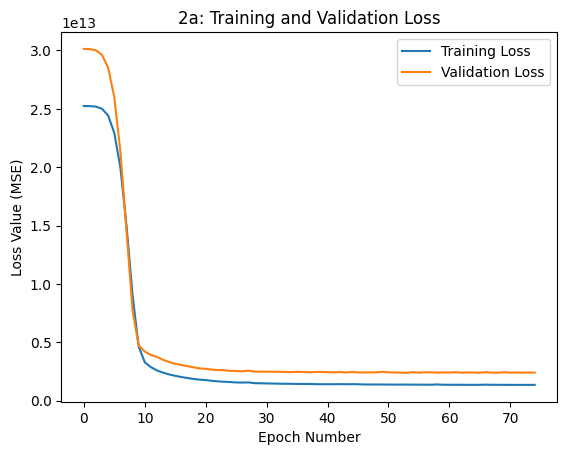


--- Section 2a Final Results ---
Final Training Loss: 1356063060907.4495
Final Validation Loss: 2402743378596.4038
Final Validation RMSE: 1550078.5000 dollars (1.5501 millions)
Final R2 Score: 0.5246
Model Complexity (Total Parameters): 11137


In [2]:
# -------------------------------------------------------
# Section 2a: Model without one-hot encoding (using only numerical features)
# -------------------------------------------------------
print("========== Section 2a: No One-Hot Encoding (Numerical Features Only) ==========")

# Load the dataset
housing_url = 'https://raw.githubusercontent.com/HeedfulMoss/ECGR_4106_Real-Time_ML/refs/heads/main/datasets/Housing.csv'
df_2a = pd.read_csv(housing_url)

# For 2a, drop the categorical columns rather than one-hot encoding them
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
features_2a = df_2a.drop(['price'] + categorical_cols, axis=1)
targets_2a = df_2a['price'].values.reshape(-1, 1)

# Standardize the features
scaler_2a = StandardScaler()
features_2a = scaler_2a.fit_transform(features_2a)

# Split into train and validation sets
x_train_2a, x_val_2a, y_train_2a, y_val_2a = train_test_split(features_2a, targets_2a, test_size=0.2, random_state=42)
x_train_2a = torch.tensor(x_train_2a, dtype=torch.float32)
y_train_2a = torch.tensor(y_train_2a, dtype=torch.float32)
x_val_2a = torch.tensor(x_val_2a, dtype=torch.float32)
y_val_2a = torch.tensor(y_val_2a, dtype=torch.float32)

# Create DataLoaders
train_dataset_2a = TensorDataset(x_train_2a, y_train_2a)
valid_dataset_2a = TensorDataset(x_val_2a, y_val_2a)
train_loader_2a = DataLoader(dataset=train_dataset_2a, batch_size=32, shuffle=True)
validation_loader_2a = DataLoader(dataset=valid_dataset_2a, batch_size=32, shuffle=False)

# Model definition for 2a
class RegressionNet2a(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNet2a, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_2a = RegressionNet2a(input_dim=x_train_2a.shape[1]).to(device)
print("\n--- Section 2a Model Summary ---")
summary(model_2a, input_size=(x_train_2a.shape[1],))  # Print model summary

criterion_2a = nn.MSELoss()
optimizer_2a = optim.Adam(model_2a.parameters(), lr=0.01)

num_epochs = 75
training_losses_2a = []
validation_losses_2a = []

start_time = time.time()
for epoch in range(num_epochs):
    model_2a.train()
    running_loss = 0.0
    for inputs, labels in train_loader_2a:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_2a.zero_grad()
        outputs = model_2a(inputs)
        loss = criterion_2a(outputs, labels)
        loss.backward()
        optimizer_2a.step()
        running_loss += loss.item() * inputs.size(0)
    running_loss /= len(train_loader_2a.dataset)
    training_losses_2a.append(running_loss)

    model_2a.eval()
    val_loss = 0.0
    for inputs, labels in validation_loader_2a:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_2a(inputs)
        loss = criterion_2a(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
    val_loss /= len(validation_loader_2a.dataset)
    validation_losses_2a.append(val_loss)
    rmse_epoch = np.sqrt(val_loss)
    print(f'[2a] Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss:.4f}, Validation Loss: {val_loss:.4f}, RMSE: {rmse_epoch:.4f}')
end_time = time.time()
print(f"[2a] Training time: {end_time - start_time:.2f} seconds")

plt.figure()
plt.plot(training_losses_2a, label='Training Loss')
plt.plot(validation_losses_2a, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value (MSE)')
plt.title('2a: Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate final performance for 2a
final_rmse_2a, r2_2a = evaluate_model(model_2a, validation_loader_2a)
params_2a = count_parameters(model_2a)
print("\n--- Section 2a Final Results ---")
print(f"Final Training Loss: {training_losses_2a[-1]:.4f}")
print(f"Final Validation Loss: {validation_losses_2a[-1]:.4f}")
print(f"Final Validation RMSE: {final_rmse_2a:.4f} dollars ({final_rmse_2a/1e6:.4f} millions)")
print(f"Final R2 Score: {r2_2a:.4f}")
print(f"Model Complexity (Total Parameters): {params_2a}")

2.b. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture, but this time also add on-hot encoding. Please plot the training and validation results and report the final accuracy and model complexity. Do you see the meaningful changes against 2.b. (20pt)


========== Section 2b: With One-Hot Encoding ==========

--- Section 2b Model Summary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 248]           3,472
            Linear-2                   [-1, 64]          15,936
            Linear-3                    [-1, 8]             520
            Linear-4                    [-1, 1]               9
Total params: 19,937
Trainable params: 19,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------

--- Training Section 2b ---
Epoch 1/75, Training Loss: 25234545285289.1016, Validation Loss: 30128634929978.7148, RMSE: 5488955.7231
Epoch 2/75, Training Loss: 25229786462602.5703, Validation Loss: 3011425904

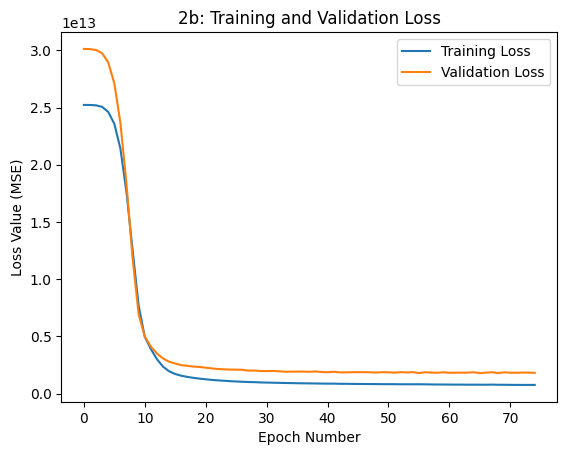


--- Section 2b Final Results ---
Final Training Loss: 755086697575.3395
Final Validation Loss: 1811464315857.0276
Final Validation RMSE: 1345906.5000 dollars (1.3459 millions)
Final R2 Score: 0.6416
Model Complexity (Total Parameters): 19937


In [3]:
# -------------------------------------------------------
# Section 2b: Model with one-hot encoding (moderate complexity network)
# -------------------------------------------------------
print("\n========== Section 2b: With One-Hot Encoding ==========")

# Load the dataset and apply one-hot encoding
df_2b = pd.read_csv(housing_url)
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
df_2b = pd.get_dummies(df_2b, columns=categorical_cols, drop_first=True)
features_2b = df_2b.drop(['price'], axis=1)
targets_2b = df_2b['price'].values.reshape(-1, 1)

# Standardize the features
scaler_2b = StandardScaler()
features_2b = scaler_2b.fit_transform(features_2b)

# Split into train and validation sets
x_train_2b, x_val_2b, y_train_2b, y_val_2b = train_test_split(features_2b, targets_2b, test_size=0.2, random_state=42)
x_train_2b = torch.tensor(x_train_2b, dtype=torch.float32)
y_train_2b = torch.tensor(y_train_2b, dtype=torch.float32)
x_val_2b = torch.tensor(x_val_2b, dtype=torch.float32)
y_val_2b = torch.tensor(y_val_2b, dtype=torch.float32)

# Create DataLoaders
train_dataset_2b = TensorDataset(x_train_2b, y_train_2b)
valid_dataset_2b = TensorDataset(x_val_2b, y_val_2b)
train_loader_2b = DataLoader(dataset=train_dataset_2b, batch_size=32, shuffle=True)
validation_loader_2b = DataLoader(dataset=valid_dataset_2b, batch_size=32, shuffle=False)

# Model definition for 2b
class RegressionNet2b(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNet2b, self).__init__()
        self.fc1 = nn.Linear(input_dim, 248)
        self.fc2 = nn.Linear(248, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_2b = RegressionNet2b(input_dim=x_train_2b.shape[1]).to(device)
print("\n--- Section 2b Model Summary ---")
summary(model_2b, input_size=(x_train_2b.shape[1],))  # Print model summary

criterion_2b = nn.MSELoss()
optimizer_2b = optim.Adam(model_2b.parameters(), lr=0.01)

print("\n--- Training Section 2b ---")
start_time = time.time()
training_losses_2b, validation_losses_2b = train_and_evaluate(model_2b, train_loader_2b, validation_loader_2b, criterion_2b, optimizer_2b, num_epochs)
end_time = time.time()
print(f"[2b] Training time: {end_time - start_time:.2f} seconds")

plt.figure()
plt.plot(training_losses_2b, label='Training Loss')
plt.plot(validation_losses_2b, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value (MSE)')
plt.title('2b: Training and Validation Loss')
plt.legend()
plt.show()

final_rmse_2b, r2_2b = evaluate_model(model_2b, validation_loader_2b)
params_2b = count_parameters(model_2b)
print("\n--- Section 2b Final Results ---")
print(f"Final Training Loss: {training_losses_2b[-1]:.4f}")
print(f"Final Validation Loss: {validation_losses_2b[-1]:.4f}")
print(f"Final Validation RMSE: {final_rmse_2b:.4f} dollars ({final_rmse_2b/1e6:.4f} millions)")
print(f"Final R2 Score: {r2_2b:.4f}")
print(f"Model Complexity (Total Parameters): {params_2b}")

2.c increase the complexity of the network for problem 2. b and compare your results against 2.b. (10pt)


========== Section 2c: Increased Model Complexity ==========

--- Section 2c Model Summary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           7,168
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                    [-1, 1]              33
Total params: 181,761
Trainable params: 181,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.69
Estimated Total Size (MB): 0.70
----------------------------------------------------------------

--- Training Section 2c ---
Epoch 1/75, Training Loss: 25219836784677.578

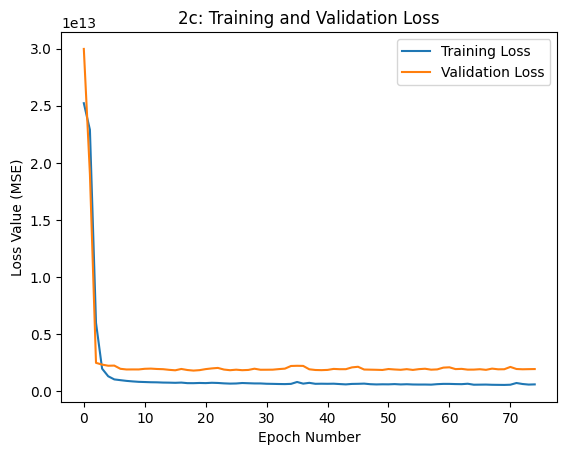


--- Section 2c Final Results ---
Final Training Loss: 593819437713.6146
Final Validation Loss: 1936698102023.0459
Final Validation RMSE: 1391653.0000 dollars (1.3917 millions)
Final R2 Score: 0.6168
Model Complexity (Total Parameters): 181761


In [4]:
# -------------------------------------------------------
# Section 2c: Increased model complexity (using one-hot encoding)
# -------------------------------------------------------
print("\n========== Section 2c: Increased Model Complexity ==========")
# We use the same one-hot encoded data from 2b.

# Model definition for 2c with additional layers and more neurons
class ComplexRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(ComplexRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

model_2c = ComplexRegressionNet(input_dim=x_train_2b.shape[1]).to(device)
print("\n--- Section 2c Model Summary ---")
summary(model_2c, input_size=(x_train_2b.shape[1],))  # Print model summary

criterion_2c = nn.MSELoss()
optimizer_2c = optim.Adam(model_2c.parameters(), lr=0.01)

print("\n--- Training Section 2c ---")
start_time = time.time()
training_losses_2c, validation_losses_2c = train_and_evaluate(model_2c, train_loader_2b, validation_loader_2b, criterion_2c, optimizer_2c, num_epochs)
end_time = time.time()
print(f"[2c] Training time: {end_time - start_time:.2f} seconds")

plt.figure()
plt.plot(training_losses_2c, label='Training Loss')
plt.plot(validation_losses_2c, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value (MSE)')
plt.title('2c: Training and Validation Loss')
plt.legend()
plt.show()

final_rmse_2c, r2_2c = evaluate_model(model_2c, validation_loader_2b)
params_2c = count_parameters(model_2c)
print("\n--- Section 2c Final Results ---")
print(f"Final Training Loss: {training_losses_2c[-1]:.4f}")
print(f"Final Validation Loss: {validation_losses_2c[-1]:.4f}")
print(f"Final Validation RMSE: {final_rmse_2c:.4f} dollars ({final_rmse_2c/1e6:.4f} millions)")
print(f"Final R2 Score: {r2_2c:.4f}")
print(f"Model Complexity (Total Parameters): {params_2c}")

Analyze results for all sectoins

In [5]:
# -------------------------------------------------------
# Final Comparison Across Sections
# -------------------------------------------------------
results_summary = pd.DataFrame({
    "Section": ["2a", "2b", "2c"],
    "Final Training Loss": [training_losses_2a[-1], training_losses_2b[-1], training_losses_2c[-1]],
    "Final Validation Loss": [validation_losses_2a[-1], validation_losses_2b[-1], validation_losses_2c[-1]],
    "Final Validation RMSE (dollars)": [final_rmse_2a, final_rmse_2b, final_rmse_2c],
    "Final Validation RMSE (millions)": [final_rmse_2a/1e6, final_rmse_2b/1e6, final_rmse_2c/1e6],
    "R2 Score": [r2_2a, r2_2b, r2_2c],
    "Model Parameters": [params_2a, params_2b, params_2c]
})

print("\n========== Comparison of All Sections ==========")
print(results_summary)


========== Comparison of All Sections ==========
  Section  Final Training Loss  Final Validation Loss  \
0      2a         1.356063e+12           2.402743e+12   
1      2b         7.550867e+11           1.811464e+12   
2      2c         5.938194e+11           1.936698e+12   

   Final Validation RMSE (dollars)  Final Validation RMSE (millions)  \
0                        1550078.5                          1.550078   
1                        1345906.5                          1.345906   
2                        1391653.0                          1.391653   

   R2 Score  Model Parameters  
0  0.524639             11137  
1  0.641619             19937  
2  0.616842            181761  
